## Metabolite and lipid differential expression analysis across spatial transcriptomics cell types

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

#### Read multi-modal aligned data (3 tissues)

In [2]:
tissue = 'IRI1'
msi_csv = pd.read_csv(f"../../COAST_results/3_multimodal_metadata_deisotoped/multimodal_{tissue}_metadata_deisotoped.csv", index_col=0)
mm_meta = msi_csv.iloc[:,0:5]
msi_csv = msi_csv.iloc[:,5:]
msi1 = ad.AnnData(X=msi_csv.values, obs=mm_meta, var=pd.DataFrame(index=msi_csv.columns))
msi1.var['numeric_index'] = pd.to_numeric(msi1.var.index, errors='coerce')
msi1.var_names = msi1.var['numeric_index'].astype(str)

tissue = 'IRI2'
msi_csv = pd.read_csv(f"../../COAST_results/3_multimodal_metadata_deisotoped/multimodal_{tissue}_metadata_deisotoped.csv", index_col=0)
mm_meta = msi_csv.iloc[:,0:5]
msi_csv = msi_csv.iloc[:,5:]
msi2 = ad.AnnData(X=msi_csv.values, obs=mm_meta, var=pd.DataFrame(index=msi_csv.columns))
msi2.var['numeric_index'] = pd.to_numeric(msi2.var.index, errors='coerce')
msi2.var_names = msi2.var['numeric_index'].astype(str)

tissue = 'IRI3'
msi_csv = pd.read_csv(f"../../COAST_results/3_multimodal_metadata_deisotoped/multimodal_{tissue}_metadata_deisotoped.csv", index_col=0)
mm_meta = msi_csv.iloc[:,0:5]
msi_csv = msi_csv.iloc[:,5:]
msi3 = ad.AnnData(X=msi_csv.values, obs=mm_meta, var=pd.DataFrame(index=msi_csv.columns))
msi3.var['numeric_index'] = pd.to_numeric(msi3.var.index, errors='coerce')
msi3.var_names = msi1.var['numeric_index'].astype(str)

In [3]:
multimodal_data = ad.concat([msi1, msi2, msi3], join='outer', label='batch', keys=['tissue1', 'tissue2', 'tissue3'])

In [4]:
multimodal_data = multimodal_data[multimodal_data.obs['ct_label']!='interstitial cells']
multimodal_data = multimodal_data[multimodal_data.obs['ct_label']!='undetermined']

#### Differential Expression

In [5]:
multimodal_data.obs["ct_label"] = multimodal_data.obs["ct_label"].astype("category")

# Run differential expression
sc.tl.rank_genes_groups(
    multimodal_data,
    groupby="ct_label",
    method="wilcoxon",  
    use_raw=False,
    n_genes=20
)

##### Plot

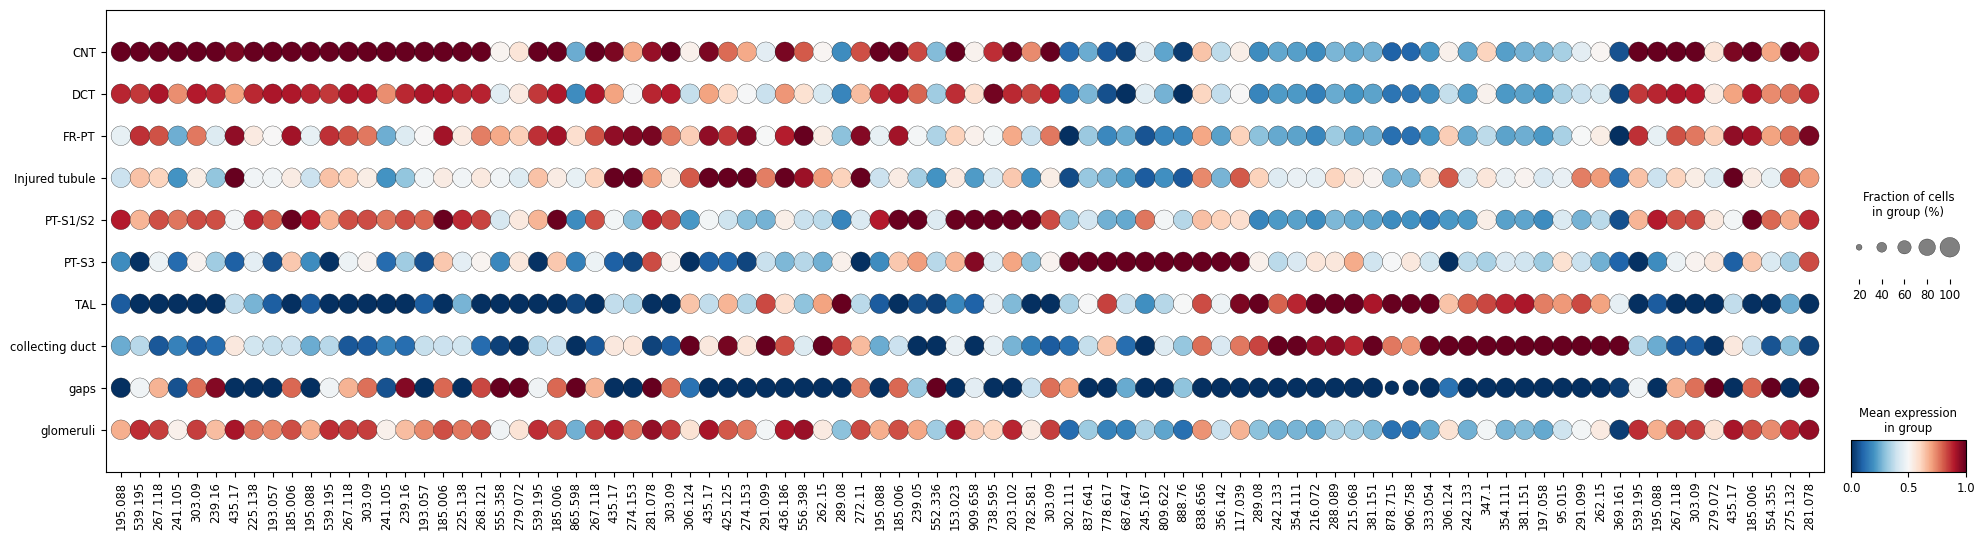

In [15]:
de_df = sc.get.rank_genes_groups_df(multimodal_data, group=None)
sig_hits = de_df[de_df["pvals_adj"] < 0.05]

top_genes = (
    sig_hits
    .sort_values(["group", "pvals_adj"])
    #.drop_duplicates(subset=["names"])  
    .groupby("group")
    .head(10)                            
    .names
    #.unique()
    .tolist()
)

# Plot 
sc.pl.dotplot(
    multimodal_data,
    var_names=top_genes,
    groupby="ct_label",
    standard_scale='var',
    cmap='RdBu_r',
    figsize=(24, 6),
    #save='dotplot.svg'
)


#### Upset plot

<Figure size 1200x600 with 0 Axes>

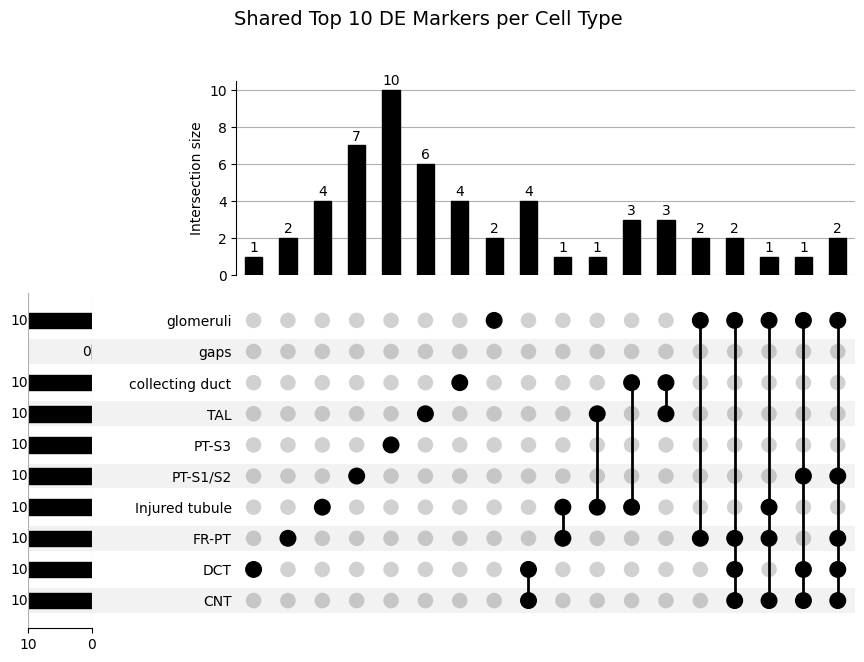

Top marker sets per cell type:
CNT (10 markers): 241.105, 185.006, 267.118, 539.195, 239.16, 225.138, 303.09, 195.088, 435.17, 193.057
DCT (10 markers): 241.105, 267.118, 539.195, 239.16, 225.138, 268.121, 303.09, 195.088, 185.006, 193.057
FR-PT (10 markers): 281.078, 865.598, 267.118, 539.195, 279.072, 303.09, 555.358, 185.006, 274.153, 435.17
Injured tubule (10 markers): 436.186, 262.15, 425.125, 272.11, 289.08, 556.398, 306.124, 435.17, 274.153, 291.099
PT-S1/S2 (10 markers): 239.05, 552.336, 153.023, 782.581, 738.595, 303.09, 195.088, 185.006, 203.102, 909.658
PT-S3 (10 markers): 245.167, 356.142, 302.111, 837.641, 838.656, 809.622, 117.039, 687.647, 778.617, 888.76
TAL (10 markers): 381.151, 242.133, 333.054, 216.072, 289.08, 215.068, 906.758, 288.089, 878.715, 354.111
collecting duct (10 markers): 381.151, 242.133, 262.15, 369.161, 347.1, 95.015, 306.124, 197.058, 354.111, 291.099
gaps (0 markers): 
glomeruli (10 markers): 185.006, 267.118, 539.195, 279.072, 275.132, 554.355, 303

In [21]:
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt

top_n = 10  
df = sig_hits.copy()  

# top per ct
top_features = (
    df.sort_values(by="scores", ascending=False)
      .groupby("group")["names"]
      .head(top_n)
      .groupby(df["group"])
      .apply(set)
)

data_dict = {group: list(features) for group, features in top_features.items()}

upset_data = from_contents(data_dict)

# plot
plt.figure(figsize=(12, 6))
up = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    sort_categories_by=None,
    sort_by='degree'
)
up.plot()
plt.suptitle(f"Shared Top {top_n} DE Markers per Cell Type", fontsize=14)
plt.savefig("shared_markers_upset.svg", format="svg", dpi=200, bbox_inches="tight")
plt.show()

print("Top marker sets per cell type:")
for g, feats in data_dict.items():
    print(f"{g} ({len(feats)} markers): {', '.join(feats)}")